# Playgroung Augut 2021 
# LightGBM + Random search + k-fold Cross Validation

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import mean

# Load Data

In [4]:
sample_subm = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')
X_test0 = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv', index_col='id')
X_train0 = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv', index_col='id')

# EDA

In [5]:
X_train0.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.511213,51.378476,0.107155,0.050010,3595.133426,8.205953,164.508753,0.375533,16.669745,1.190382,...,4856.812768,22.579100,2.030554,0.079692,1.555097,2.417556,0.537484,1.576900,8.048805,6.813920
std,0.307884,42.396636,1.322200,0.792368,6072.401061,5.475723,183.335563,0.813597,99.758709,0.099700,...,8501.609009,14.849390,0.900211,0.587780,9.253785,0.892563,0.226589,0.646306,5.647368,7.940179
min,-0.069273,-17.000000,-7.895580,-1.475560,-7589.280000,-3.291050,-40.967200,-4.143080,-502.813000,0.934037,...,-12695.700000,-4.059170,0.057800,-1.998800,-24.686300,-1.131980,0.005249,-0.646967,-0.842397,0.000000
25%,0.251287,18.000000,-0.611172,-0.719418,163.864750,4.110127,27.894900,-0.026245,-17.392025,1.132640,...,73.203100,11.525450,1.471650,-0.408975,-4.004925,1.906718,0.359646,1.215810,3.732800,1.000000
50%,0.514962,41.000000,0.253815,0.004099,943.000500,7.472445,91.005250,0.619862,8.714945,1.170370,...,1060.025000,19.993200,1.660830,0.215710,0.759942,2.340430,0.531348,1.451285,7.182205,4.000000
75%,0.777323,75.000000,0.759249,0.765456,4115.355000,11.030950,240.843750,0.933855,55.407625,1.218880,...,5572.982500,32.271625,2.320085,0.503134,6.202502,2.910020,0.709807,1.901632,10.998550,10.000000
max,1.072070,273.000000,9.768590,1.680190,37847.500000,35.078000,947.143000,4.010380,465.956000,1.712450,...,54334.600000,79.912400,5.403020,1.944190,42.890400,5.576040,1.105400,4.492620,34.019200,42.000000


In [6]:
#CREATE RESUME TABLE
def df_info(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if 'loss' in df:
        corrSP = df.corr(method='pearson').loss
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    
    return df_resume

pd.set_option('max_rows', None)

In [7]:
#See resume table
df_info(X_train0)
#df_info(X_test0)

,type,Sample,% of NaN,Corr_with_y,Duplicates,Amount Uniques,Uniques,Outliers
f0,float64,"[-0.00234981, 0.784462, 0.317816, 0.210753, 0....",0,0.008921,0,223000,Several,0
f1,int64,"[59, 145, 19, 17, 20]",0,0.011847,0,289,Several,0
f2,float64,"[0.766739, -0.463845, -0.432571, -0.616454, 0....",0,-0.005064,0,232906,Several,1834
f3,float64,"[-1.35046, -0.530421, -0.382644, 0.946362, -0....",0,-0.018853,0,225458,Several,0
f4,float64,"[42.2727, 27324.9, 1383.26, -119.253, 74.302]",0,0.005524,0,235741,Several,0
f5,float64,"[16.6857, 3.47545, 19.7129, 4.08235, 12.3065]",0,0.009387,0,212229,Several,0
f6,float64,"[30.3599, 160.498, 31.1026, 185.257, 72.186]",0,0.005509,0,226317,Several,0
f7,float64,"[1.2673, 0.828007, -0.515354, 1.38331, -0.233964]",0,0.000762,0,222121,Several,0
f8,float64,"[0.392007, 3.73586, 34.4308, -47.5214, 24.3991]",0,0.007545,0,237743,Several,0
f9,float64,"[1.09101, 1.28138, 1.2421, 1.0913, 1.10151]",0,0.005822,0,46865,Several,0


In [8]:
#Check correlations
X_train1 = pd.DataFrame(X_train0)

c = X_train1.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

print(so[100:150])

loss  loss    1.000000
f9    f42     0.034008
f42   f9      0.034008
f25   f30     0.032694
f30   f25     0.032694
f64   f14     0.032377
f14   f64     0.032377
f62   f9      0.030315
f9    f62     0.030315
f25   loss    0.030164
loss  f25     0.030164
f64   f38     0.029751
f38   f64     0.029751
f64   f53     0.029487
f53   f64     0.029487
f62   f53     0.029178
f53   f62     0.029178
f87   f52     0.028849
f52   f87     0.028849
f30   f18     0.028433
f18   f30     0.028433
f92   f2      0.028413
f2    f92     0.028413
f30   f8      0.027659
f8    f30     0.027659
f42   f41     0.027195
f41   f42     0.027195
f2    f33     0.026939
f33   f2      0.026939
f52   loss    0.026566
loss  f52     0.026566
f8    f44     0.026341
f44   f8      0.026341
f54   f55     0.026159
f55   f54     0.026159
f17   f37     0.025872
f37   f17     0.025872
loss  f13     0.025730
f13   loss    0.025730
f9    f71     0.025561
f71   f9      0.025561
f84   f9      0.025526
f9    f84     0.025526
f89   f64  

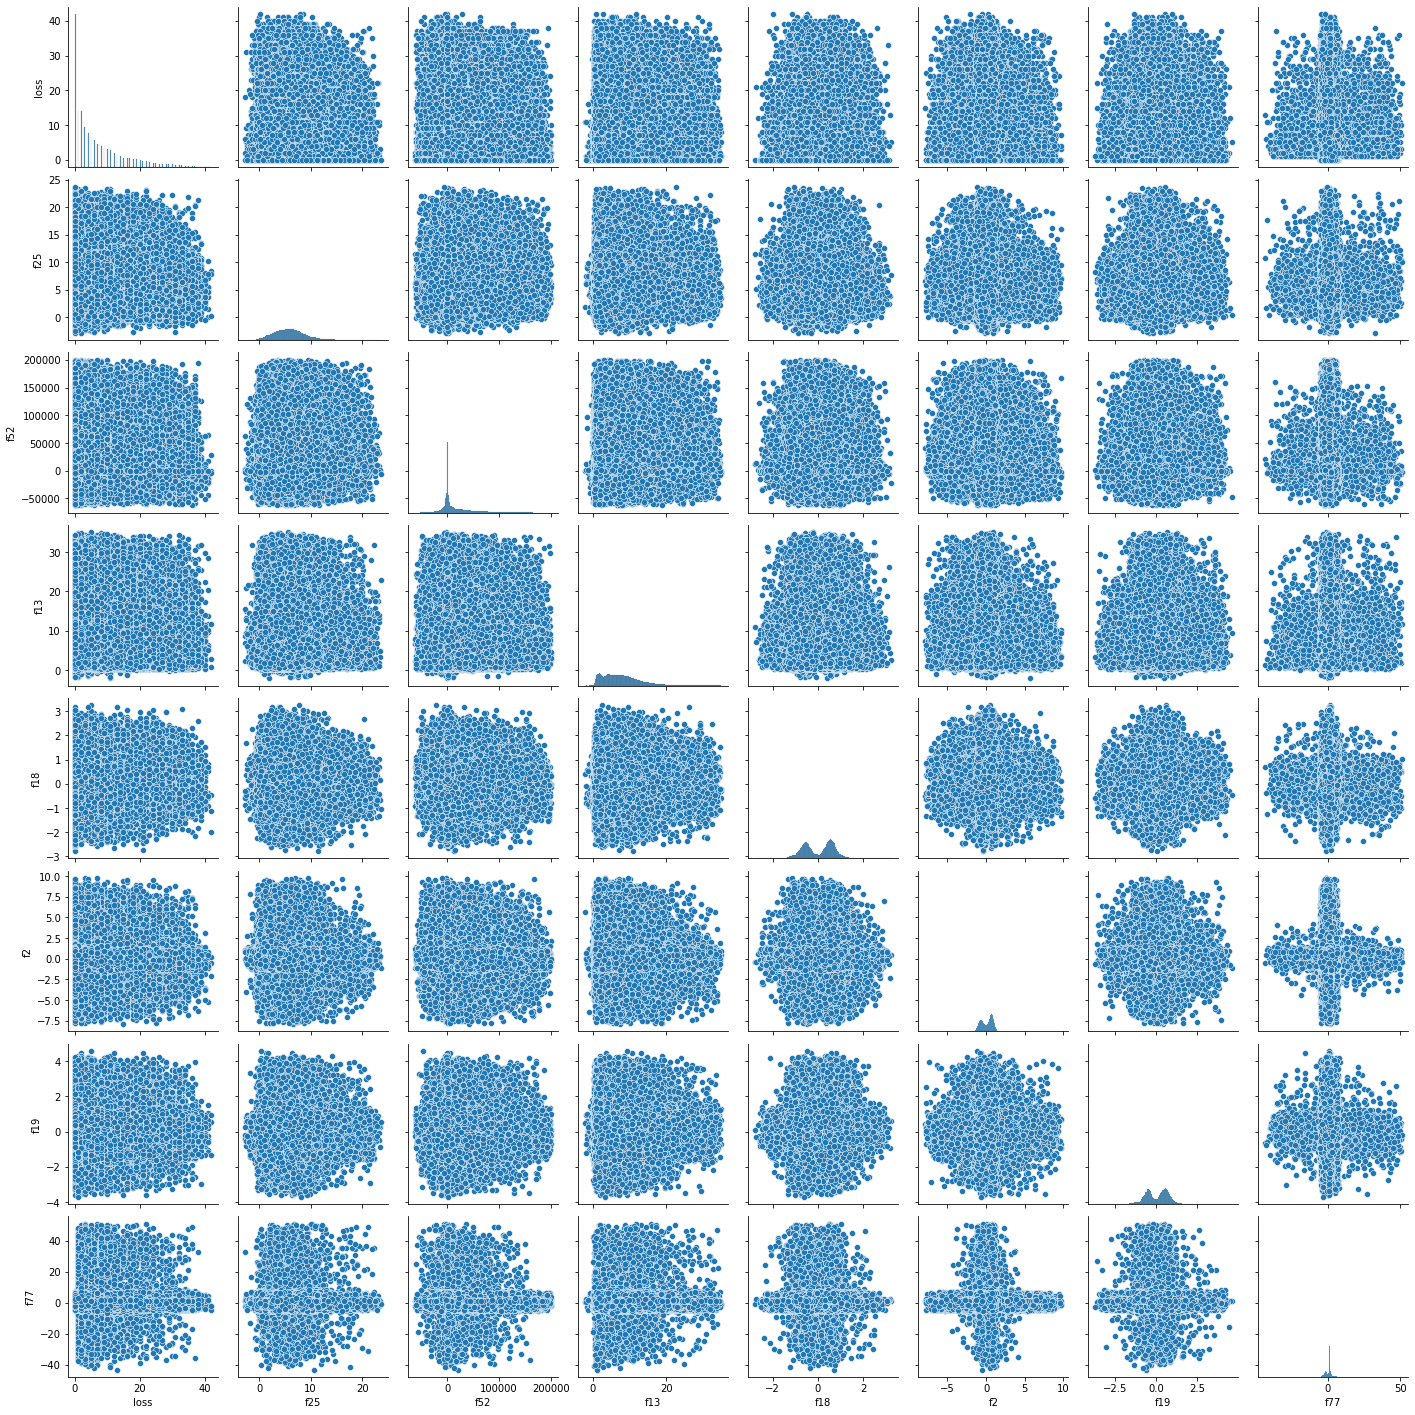

In [9]:
# Visualize relevant variables and outliers in Train set
sns.pairplot(X_train0[['loss', 'f25', 'f52', 'f13', 
                    'f18', 'f2', 'f19','f77']])

Nothing special to do here... let the ML Boost model do the job.

# ML Model

**Train and Test Split - this is not done, as it is incldued the cross validation procedure**

In [10]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

X = X_train0.drop(['loss'], axis = 1)
y = X_train0.loss

print("Ok")
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=82)
#train_data = lightgbm.Dataset(train_X, label=train_y)
#test_data = lightgbm.Dataset(test_X, label=test_y)

Ok


# LightGBM Model

**Random Search for hyperparameter tunning.** <br/>
It is possible to Run a couple of rounds, reducing the variable space according to the primarly results. <br/>
**Makes use of k-fold cross validation.**

In [12]:
import lightgbm

pp = 0
n_b_r = 0
e_s_r = 0

#np.random.seed(seed=68)

#Set the minimum error arbitrarily large
minr = 9999999999999
#How many runs to perform using randomly selected hyperparameters
iterations = 1 #50
seeds = 1 #3
for i in range(iterations):
    print('ITERATION: ', i+1)
    try:
        params = {} #initialize parameters
        params['boosting_type'] = np.random.choice(['gbdt']) #, 'goss']) #, 'dart'])  #'boosting' 
        params['metric'] = 'RMSE'
        params['learning_rate'] = np.random.uniform(0.0169, 0.0175)  #1st ROUND - (0.01, 0.9)        
        params['num_leaves'] = np.random.randint(16, 20)  #1st ROUND - (10, 200)  #OLD -31
        params['min_data'] = np.random.randint(14, 18)  #1st ROUND - (5, 50)
        params['max_depth'] = np.random.randint(13,16)  #1st ROUND - (-1, 30)
        params['feature_fraction'] = np.random.uniform(0.130, 0.145)  #1st ROUND (0.05, 0.95) 
        params['bagging_fraction'] = np.random.uniform(0.77, 0.9)  #1st ROUND (0.05, 0.95) 
        params['bagging_freq'] = np.random.randint(15, 18)   #1st ROUND 
        its = np.random.randint(3020, 3100)   #1st ROUND (1000, 8000) 
        e_stop = np.random.randint(65, 80)   #1st ROUND (50, 500) 
        params['verbose'] = -1
        print(params, its, e_stop)     

        train_data = lightgbm.Dataset(X, label=y)  
        
        rms_j = []
        for j1 in range(seeds):
            modelLGBM = lightgbm.cv(params,
                                   train_data,
                                    num_boost_round=its,
                                    nfold=3,
                                    early_stopping_rounds=e_stop,
                                    seed=np.random.randint(1, 9999),
                                    verbose_eval = -1 )  #silent evaluations
            #print(modelLGBM)
            a = map(lambda x: np.mean(modelLGBM[x]), modelLGBM)
            rms0 = list(a)         
            rms_j.append(rms0[0])
        print(rms_j)
        rms_j_aux = 0
        for k in range(len(rms_j)):
            rms_j_aux += rms_j[k]
        rms3 = rms_j_aux / len(rms_j)
        print("RMS average: ", rms3)

        if rms3 < minr:
            minr = rms3
            pp = params 
            n_b_r = its
            e_s_r = e_stop
    except Exception as e: 
        print('***** Failed - ', e)
        
print("*" * 100)
print('Minimum RMS: ', minr)
print('parameters = ', pp)
print('num_boost_round =', n_b_r)
print('early_stopping_rounds = ', e_s_r)

ITERATION:  1
{'boosting_type': 'gbdt', 'metric': 'RMSE', 'learning_rate': 0.017347399875470747, 'num_leaves': 16, 'min_data': 15, 'max_depth': 14, 'feature_fraction': 0.13546236034844183, 'bagging_fraction': 0.8880941138223688, 'bagging_freq': 15, 'verbose': -1} 3050 69
[7.860289265679159]
RMS average:  7.860289265679159
****************************************************************************************************
Minimum RMS:  7.860289265679159
parameters =  {'boosting_type': 'gbdt', 'metric': 'RMSE', 'learning_rate': 0.017347399875470747, 'num_leaves': 16, 'min_data': 15, 'max_depth': 14, 'feature_fraction': 0.13546236034844183, 'bagging_fraction': 0.8880941138223688, 'bagging_freq': 15, 'verbose': -1}
num_boost_round = 3050
early_stopping_rounds =  69


Training until validation scores don't improve for 74 rounds
Early stopping, best iteration is:
[1752]	valid_0's rmse: 7.80643
RMS:  7.812247819929934


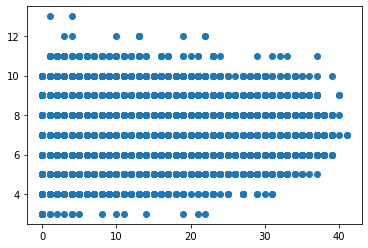

In [13]:
import lightgbm

t_size = 0.25 # can be changed 

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=t_size)
train_data = lightgbm.Dataset(train_X, label=train_y)
test_data = lightgbm.Dataset(test_X, label=test_y)

parameters =  {'boosting_type': 'gbdt',    #'goss','dart'
               'metric': 'RMSE',
               'learning_rate': 0.01734225667880825, 
               'num_leaves': 17, 
               'min_data': 15,
               'max_depth': 14,
               'feature_fraction': 0.13301919009818083,  
               'bagging_fraction': 0.8647874600606483,  
               'bagging_freq': 16,  
               'verbose': -1}  #silent errors
#parameters = pp
n_b_r =  3070
e_s_r =  74

modelLGBM = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=n_b_r, 
                       early_stopping_rounds=e_s_r, 
                        verbose_eval = -1 )  #silent evaluations

y_pred2 = modelLGBM.predict(test_X)
preds3 = [round(value) for value in y_pred2]

# evaluate predictions
rms3 = mean_squared_error(test_y, preds3, squared=False)
print("RMS: ", rms3)
      
g2=plt.scatter(test_y, preds3)

# Final Predict

[7.6080756  5.00414255 7.80428658 ... 6.10829587 5.39263583 7.29571125]


<AxesSubplot:>

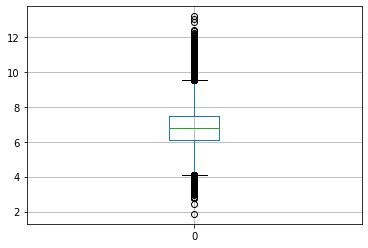

In [14]:
preds1F = modelLGBM.predict(X_test0)

print(preds1F)

pd.DataFrame(preds1F).boxplot(return_type='axes')

# Submission 

In [15]:
output = pd.DataFrame({'id': X_test0.index,
                      'loss': preds1F})
output.set_index('id', inplace=True)
print(len(output))
output.to_csv('submission.csv')

150000
